# Handwritten Digit Recognition

In this project, I will train a neural network that will be able to predict handwritten digits ranging between 0 and 9. As this is multiclass recognition, we will use softmax as an output layer instead of sigmoid. 

This is the most basic learning project for supervised learning. The logic used in this project can be used for countless practical applications, roughly ranging from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks.

Instead of downloading the MNIST dataset, I have the dataset contained in separate folder that I will access through python commands.

We start by importing all useful packages

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
%matplotlib widget
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

from public_tests import * 

from autils import *
from lab_utils_softmax import plt_softmax
np.set_printoptions(precision=2)

Here is a comparison of the 3 most used activation functions while building a Neural Network.

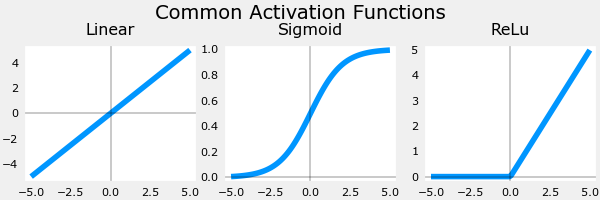

In [30]:
plt_act_trio()

Defining Softmax function (which is used in a multiclass scenario so a single output is chosen from more than 2 inputs)

![alt text](Softmax_Equation.png)

In [31]:
def my_softmax(z):  
    """ Softmax converts a vector of values to a probability distribution.
    Args:
      z (ndarray (N,))  : input data, N features
    Returns:
      a (ndarray (N,))  : softmax of z
    """    
    ez = np.exp(z)
    a = ez/np.sum(ez)
    
    return a

Testing my implementation by throwing random inputs

In [33]:
z = np.array([1., 2., 3., 4.])
a = my_softmax(z)
atf = tf.nn.softmax(z)
print(f"my_softmax(z):         {a}")
print(f"tensorflow softmax(z): {atf}")

test_my_softmax(my_softmax)


my_softmax(z):         [0.03 0.09 0.24 0.64]
tensorflow softmax(z): [0.03 0.09 0.24 0.64]
 All tests passed.


Visualize by changing input through the slider to observe the output

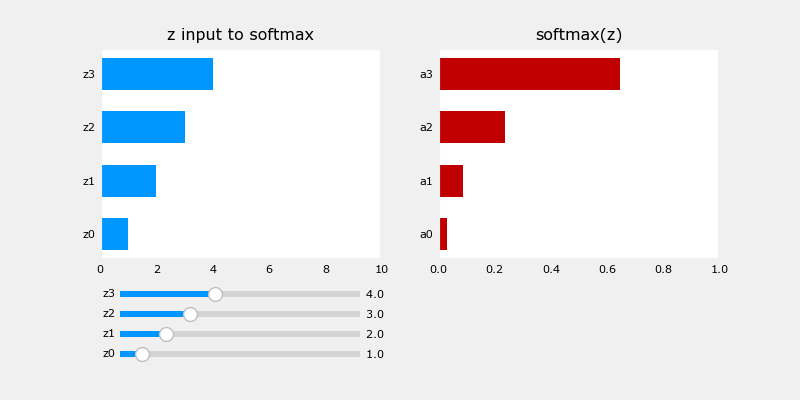

In [34]:
plt.close("all")
plt_softmax(my_softmax)

**Dataset Loading**

**Few facts about the data**

1. We have 5000 images and labels. 

2. Each image is a 20x20 pixel grayscale image and the 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector.

3. Each training examples becomes a single row in our data matrix X which results in X vector having dimensions (5000 x 400)

In [36]:
X, y = load_data()

Note that as we are dealing with images, X and y will contain mulitdimensional arrays and values will range from 0 to 9, representing the digits

In [40]:
print ('The first element of X is: ', X[0])

The first element of X is:  [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  8.56e-06  1.94e-06 -7.37e-04
 -8.13e-03 -1.86e-02 -1.87e-02 -1.88e-02 -1.91e-02 -1.64e-02 -3.78e-03
  3.30e-04  1.28e-05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.16e-04  1.20e-04 -1.40e-02 -2.85e-02  8.04e-02
  2.67e-01  2.74e-01  2.79e-01  2.74e-01  2.25e-0

In [38]:
print ('The first element of y is: ', y[0,0])
print ('The last element of y is: ', y[-1,0])

The first element of y is:  0
The last element of y is:  9


**Dimensions**

In [41]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))

The shape of X is: (5000, 400)
The shape of y is: (5000, 1)


**Visualizing the Data**

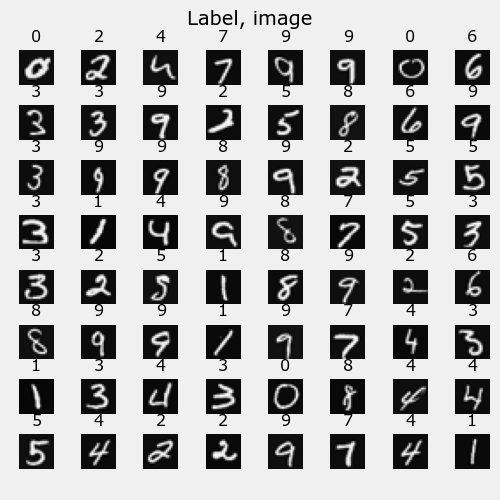

In [42]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

#fig.tight_layout(pad=0.5)
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()
    fig.suptitle("Label, image", fontsize=14)

**Model Building**

The neural network I used has two dense layers with ReLU activations followed by an output layer with a linear activation.

Since the images are of size 20x20, this gives us 400 inputs.

**Determining dimensions of Parameters W and b**

In the neural network, assuming that the current layer contains **i** neurons and the next layer contains **j** neurons

- **W** parameter will have dimension i x j

- **b** will be a vector with j elements

In [43]:
## I use Keras Sequential model and Dense Layer with a ReLU activation to construct the three layer network as per my description.

tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [               
        ### START CODE HERE ### 
        tf.keras.layers.InputLayer((400,)),
        tf.keras.layers.Dense(25, activation="relu", name="L1"),
        tf.keras.layers.Dense(15, activation="relu", name="L2"),
        tf.keras.layers.Dense(10, activation="linear", name="L3")
        ### END CODE HERE ### 
    ], name = "my_model" 
)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [44]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 25)                10025     
                                                                 
 L2 (Dense)                  (None, 15)                390       
                                                                 
 L3 (Dense)                  (None, 10)                160       
                                                                 
Total params: 10575 (41.31 KB)
Trainable params: 10575 (41.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
test_model(model, 10, 400)

All tests passed!


In [46]:
[layer1, layer2, layer3] = model.layers

Checking if the parameter dimensions are according to my theory

In [47]:
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


The code below makes use of:
- loss function, called **SparseCategoricalCrossentropy** and indicates the softmax should be included with the loss calculation by adding from_logits=True
- an optimizer. A popular choice is Adam optimizer.

In [48]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    X,y,
    epochs=40
)

Epoch 1/40
157/157 [==============================] - 1s 1ms/step - loss: 1.5174
Epoch 2/40
157/157 [==============================] - 0s 1ms/step - loss: 0.5824
Epoch 3/40
157/157 [==============================] - 0s 1ms/step - loss: 0.4001
Epoch 4/40
157/157 [==============================] - 0s 1ms/step - loss: 0.3279
Epoch 5/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2869
Epoch 6/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2569
Epoch 7/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2338
Epoch 8/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2144
Epoch 9/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2039
Epoch 10/40
157/157 [==============================] - 0s 1ms/step - loss: 0.1821
Epoch 11/40
157/157 [==============================] - 0s 1ms/step - loss: 0.1722
Epoch 12/40
157/157 [==============================] - 0s 1ms/step - loss: 0.1628
Epoch 13/40
157/157 [====

Plotting the cost to observe its behaviour

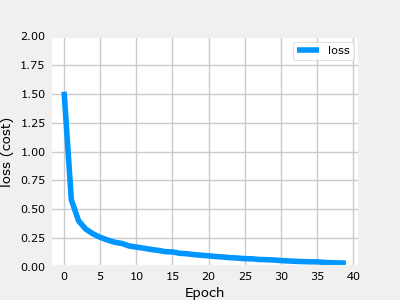

In [49]:
plot_loss_tf(history)

**Prediction**

We check our model by taking a prediction on a single entry as an input.

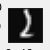

1/1 [==============================] - 0s 17ms/step
 predicting a Two: 
[[-8.63  0.24  3.51 -1.27 -8.82 -7.21 -5.43  0.16 -6.49 -7.56]]
 Largest Prediction index: 2


In [55]:
image_of_two = X[1015]
display_digit(image_of_two)

prediction = model.predict(image_of_two.reshape(1,400))  # prediction

print(f" predicting a Two: \n{prediction}")
print(f" Largest Prediction index: {np.argmax(prediction)}")

In [51]:
prediction_p = tf.nn.softmax(prediction)

print(f" predicting a Two. Probability vector: \n{prediction_p}")
print(f"Total of predictions: {np.sum(prediction_p):0.3f}")

 predicting a Two. Probability vector: 
[[4.93e-06 3.50e-02 9.25e-01 7.78e-03 4.09e-06 2.05e-05 1.21e-04 3.24e-02
  4.20e-05 1.44e-05]]
Total of predictions: 1.000


To return an integer representing the predicted target, you want the index of the largest probability. This is accomplished with the Numpy argmax function.

In [52]:
yhat = np.argmax(prediction_p)

print(f"np.argmax(prediction_p): {yhat}")

np.argmax(prediction_p): 2


Now I will compare our predictions with actual labels

1/1 [==============================] - 0s 15ms/step


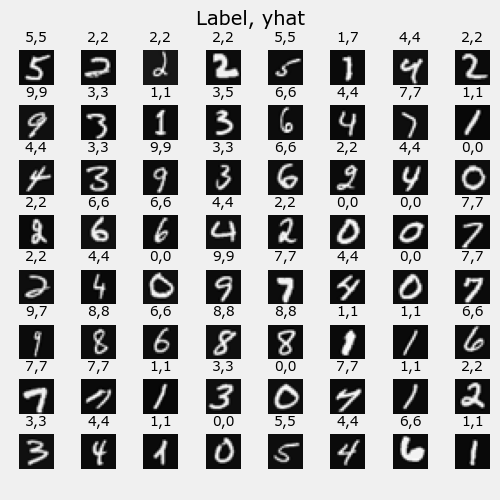

In [53]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,400))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{yhat}",fontsize=10)
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=14)
plt.show()

1/1 [==============================] - 0s 18ms/step
28 errors out of 5000 images


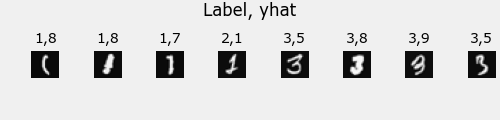

In [54]:
print( f"{display_errors(model,X,y)} errors out of {len(X)} images")